<a href="https://colab.research.google.com/github/bo-cheng-tsai/homework/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0148
Epoch [20/100], Loss: 0.0135
Epoch [30/100], Loss: 0.0133
Epoch [40/100], Loss: 0.0121
Epoch [50/100], Loss: 0.0098
Epoch [60/100], Loss: 0.0037
Epoch [70/100], Loss: 0.0021
Epoch [80/100], Loss: 0.0013
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0007


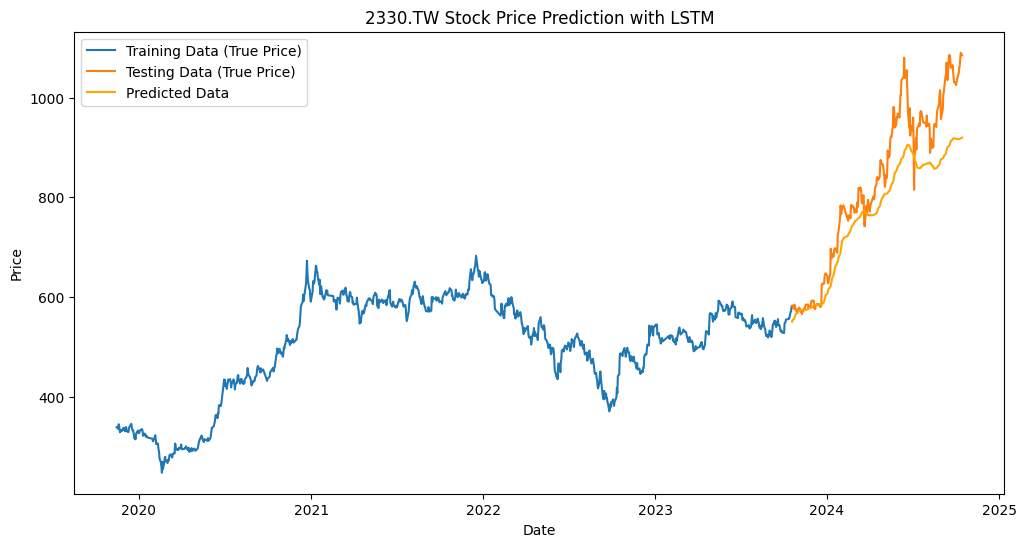

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt

# 載入股票資料
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=5*365)  # 使用五年的資料
df = yf.download(stock_id, start=start, end=end)
df = df[['Close']]

# 資料正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 資料集製作
def create_dataset(data, time_step=20):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 20  # 輸入的天數
X, y = create_dataset(scaled_data, time_step)
X = torch.from_numpy(X).float().view(-1, time_step, 1)
y = torch.from_numpy(y).float().view(-1, 1)

# 分割訓練與測試集
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# 定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50).to(x.device)
        c0 = torch.zeros(2, x.size(0), 50).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型、損失函數和優化器
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 預測
model.eval()
train_predict = model(train_X).detach().numpy()
test_predict = model(test_X).detach().numpy()

# 反正規化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_y = scaler.inverse_transform(train_y.detach().numpy())
test_y = scaler.inverse_transform(test_y.detach().numpy())

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(train_y)], train_y, label="Training Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Testing Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_predict)], test_predict, label="Predicted Data", color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{stock_id} Stock Price Prediction with LSTM")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Epoch [10/50], Loss: 0.0704
Epoch [20/50], Loss: 0.0165
Epoch [30/50], Loss: 0.0107
Epoch [40/50], Loss: 0.0086
Epoch [50/50], Loss: 0.0067


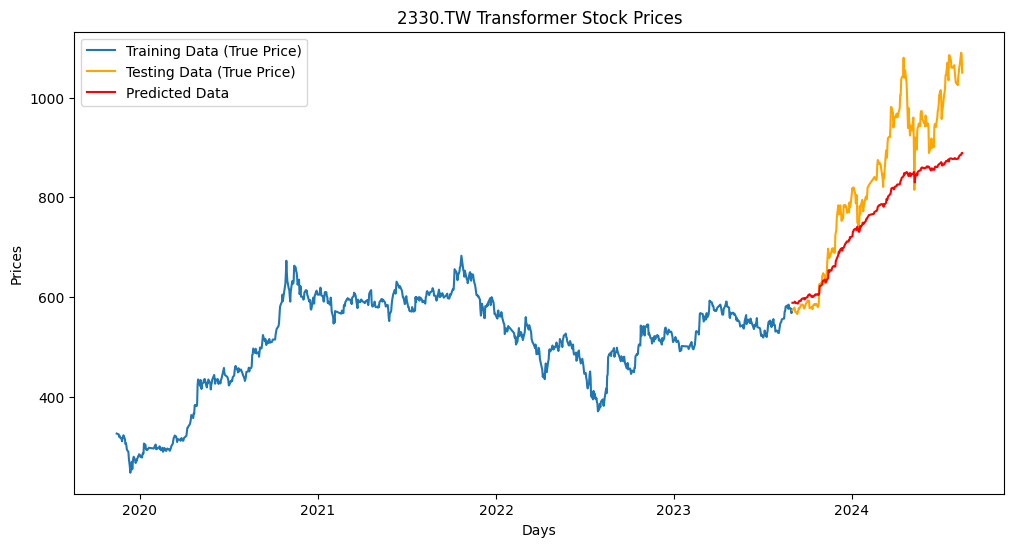

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 載入股票資料
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=5*365)  # 使用五年的資料
df = yf.download(stock_id, start=start, end=end)
df = df[['Close']]

# 正規化資料
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.values)

# 建立序列資料
def create_sequences(data, sequence_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

sequence_length = 60
X, y = create_sequences(data, sequence_length)

# 分割訓練與測試集
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# 定義 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.input_fc(src) + self.positional_encoding
        transformer_output = self.transformer(src)
        output = self.output_fc(transformer_output[:, -1, :])
        return output

# 初始化模型、損失函數和優化器
input_dim = 1
d_model = 64
nhead = 4
num_layers = 3
dim_feedforward = 128
output_dim = 1
model = TransformerModel(input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 預測
model.eval()
train_predict = model(train_X).detach().numpy()
test_predict = model(test_X).detach().numpy()

# 反正規化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_y = scaler.inverse_transform(train_y.view(-1, 1).detach().numpy())
test_y = scaler.inverse_transform(test_y.view(-1, 1).detach().numpy())

# 繪製結果
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(train_y)], train_y, label="Training Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_y)], test_y, color="orange", label="Testing Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_predict)], test_predict, color="red", label="Predicted Data")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.title(f"{stock_id} Transformer Stock Prices")
plt.legend()
plt.show()